**_Autor_**: Rubén del Mazo Rodríguez

# Red neuronal con una capa oculta

En este archivo, que se debe ver a continuación del de regresión logística, implementa una red neuronal con una capa oculta. Si la regresión logística era una "red neuronal" monocapa mononeuronal, esta red neuronal va un (primer) paso más allá, siendo de dos capas, una de ellas la capa oculta. El modelo de red neuronal cambia mucho, como no podía ser de otra manera, con respecto a la pseudo red neuronal del anterior archivo.

**Puntos principales:**

- Implementar una red neuronal de clasificación de 2 clases con una capa oculta.
- Utilizar unidades ocultas con una función de activación no lineal, como tanh.
- Calcular la pérdida de entropía cruzada (_cross entropy loss_).
- Aplicar la propagación hacia delante y hacia atrás (_forward y backward propagation_).

El objetivo de este trabajo no es entrenar una red neuronal perfectamente ajustada al conjunto de datos, sino explicar el proceso de creación y cómo funcionan.

## Contenidos
- [1 - Librerías](#1)
- [2 - Descripción general de los datos](#2)
- [3 - Regresión logística simple](#3)
- [4 - Modelo de red neuronal con dos capas (una capa oculta)](#4)
    - [4.1 - Estructura de la red neuronal](#4-1)
    - [4.2 - Inicialización de parámetros](#4-2)
    - [4.3 - Propagación hacia delante (_forward propagation_)](#4-3)
    - [4.4 - Cálculo del coste global](#4-4)
    - [4.5 - Retropropagación (_backward propagation_)](#4-5)
    - [4.6 - Actualización de los parámetros](#4-6)
    - [4.7 - Integración del modelo](#4-7)
- [5 - Evaluación del modelo](#5)
    - [5.1 - Predicción](#5-1)
    - [5.2 - Evaluación sobre el conjunto de datos](#5-2)
- [6 - Ajuste del tamaño de la capa oculta (_fine tuning_)](#6)

<a name='1'></a>
# 1 - Librerías

En primer lugar, importamos y ejecutamos las librerías necesarias:

- [numpy](https://numpy.org/doc/1.24/) es el paquete fundamental para la computación científica con Python.
- [sklearn](https://scikit-learn.org/stable/) proporciona herramientas sencillas y eficaces para la extracción y el análisis de datos. 
- [matplotlib](http://matplotlib.org) es la librería más famosa para dibujar gráficos en python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<a name='2'></a>
# 2 - Descripción general de los datos

El conjunto de datos va a consistir en un plano en dos dimensiones de puntos de dos colores (rojo = 0, azul = 1). La forma va a ser parecida a una flor. El objetivo de la red neuronal será clasificar corréctamente estos datos y establecer fronteras de separación adecuadas.

A continuación, se genera un conjunto de datos de clasificación que no es fácilmente separable linealmente:

In [2]:
def crear_dataset():
    np.random.seed(1)
    # Numero de ejemplos
    m = 400
    # Numero de puntos por clase
    N = int(m/2)
    # Dimensionalidad
    D = 2
    # Matriz de datos donde cada fila es un ejemplo
    X = np.zeros((m,D))
    # Vector de etiquetas (0 para puntos rojos, 1 para los azules)
    Y = np.zeros((m,1), dtype='uint8')
    # Tamaño maximo por petalo en la figura
    a = 4

    for etiqueta in range(2):
        x = range(N * etiqueta, N * (etiqueta + 1))
        angulo = np.linspace(etiqueta * 3.12,(etiqueta + 1) * 3.12, N) + np.random.randn(N) * 0.2
        radio = a * np.sin(4 * angulo) + np.random.randn(N) * 0.2
        # Concatenacion de arrays
        X[x] = np.c_[radio * np.sin(angulo), radio * np.cos(angulo)]
        Y[x] = etiqueta
     
    # Trasponemos pues, como se ha dicho en todo el trabajo, los ejemplos de entrenamiento son vectores columnas.
    X = X.T
    Y = Y.T

    return X, Y

`np.random.seed(1)`se utiliza para establecer la semilla para el algoritmo generador de números pseudoaleatorios en Python. Si se establece una semilla y luego se generan números aleatorios con funciones de `numpy.random`, se obtiene la misma secuencia de números aleatorios cada vez que se ejecute. Esto es útil cuando se pretende que los resultados sean reproducibles en los cálculos que involucran números aleatorios. Por tanto, útil en este archivo donde cualquier persona que lo ejecute debería obtener los mismos resultados para los que luego se sacan conclusiones.

In [3]:
X, Y = crear_dataset()

Visualicemos el conjunto de datos utilizando matplotlib. Los datos parecen una "flor" con algunos puntos rojos (etiqueta y=0) y otros azules (y=1). Con la red neuronal vamos a crear un clasificador que defina las regiones como rojas o azules.

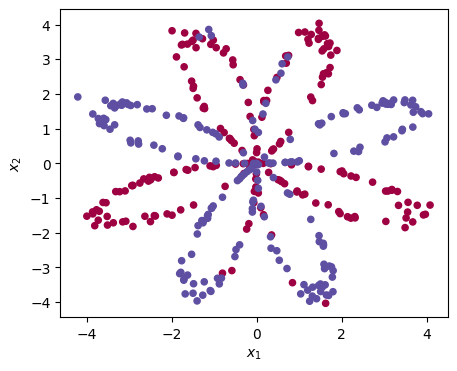

In [4]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
ax.set_ylabel(r'$x_2$')
ax.set_xlabel(r'$x_1$')
ax.scatter(X[0, :], X[1, :], c=Y, s=20, cmap=plt.cm.Spectral);

Tenemos:

- una matriz numpy X que contiene dos características (x1, x2)
- una matriz numpy (vector) Y que contiene dos etiquetas (rojo = 0, azul = 1).

Analicemos los datos: número de ejemplos de entrenamiento y dimensiones de las matrices `X` y `Y`? 

In [5]:
dimensiones_X = X.shape
dimensiones_Y = Y.shape
m_train = Y.shape[1]

print('Dimensiones de X: ' + str(dimensiones_X))
print('Dimensiones de Y: ' + str(dimensiones_Y))
print('¡Tenemos m_train = %d ejemplos de entrenamiento!' % (m_train))

Dimensiones de X: (2, 400)
Dimensiones de Y: (1, 400)
Tenemos m_train = 400 ejemplos de entrenamiento!


<table style="width:25%">
  <tr>
    <td> Dimensiones de X </td>
    <td> (2, 400) </td> 
  </tr>
  <tr>
    <td> Dimensiones de Y</td>
    <td>(1, 400) </td> 
    </tr>
    <tr>
    <td> m_train </td>
    <td> 400 </td> 
  </tr>
</table>

Es decir:

- $X \in \mathbb{R}^{n_{x}\times m} = \mathbb{R}^{2\times 400}$
- $Y \in \mathbb{R}^{n_{y}\times m} = \mathbb{R}^{1\times 400}$

<a name='3'></a>
## 3 - Regresión logística simple

Antes de construir una red neuronal completa, vamos a comprobar cómo funciona la regresión logística en este problema. Para no tener que repetir toda la estructura del archivo anterior, vamos a utilizar las funciones integradas de sklearn. Con el siguiente código se entrena un clasificador de regresión logística con el conjunto de datos.

In [6]:
clasificador = linear_model.LogisticRegressionCV();
clasificador.fit(X.T, (Y.T).reshape(400,));

La siguiente función tiene por objetivo dibujar las fronteras de separación o límites. Servirá para todo el archivo.

In [7]:
def dibujar_fronteras_limite(modelo, X, Y):
    # Establecer valores minimo y maximo y algo de margen
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generar una cuadrícula de puntos con una distancia h entre ellos
    x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predecir el valor de la función para toda la cuadrícula
    prediccion = modelo(np.c_[x_grid.ravel(), y_grid.ravel()])
    prediccion = prediccion.reshape(x_grid.shape)
    # Dibujar el contorno y los ejemplos de entrenamiento
#     El siguiente codigo daba problemas con el apartado 6, pero es perfectamente valido para representaciones individuales    
#     fig = plt.figure(figsize=(5,4))
#     ax = fig.add_subplot(111)
#     ax.contourf(x_grid, y_grid, prediccion, cmap=plt.cm.Spectral)
#     ax.set_ylabel(r'$x_2$')
#     ax.set_xlabel(r'$x_1$')
#     ax.scatter(X[0, :], X[1, :], c=Y, s=20, cmap=plt.cm.Spectral)
    plt.contourf(x_grid, y_grid, prediccion, cmap=plt.cm.Spectral)
    plt.ylabel(r'$x_2$')
    plt.xlabel(r'$x_1$')
    plt.scatter(X[0, :], X[1, :], c=Y, s=20, cmap=plt.cm.Spectral)

`numpy.ravel()` convierte un array en array 1D. En el código, `x_grid.ravel()` y `y_grid.ravel()` convierten las matrices `x_grid` y `y_grid` en arrays unidimensionales antes de concatenarlos con `np.c_[]`. Esto se hace para que el modelo pueda predecir el valor de la función para toda la cuadrícula de puntos generada.

Text(0.5, 1.0, 'Clasificación con Regresión Logística')

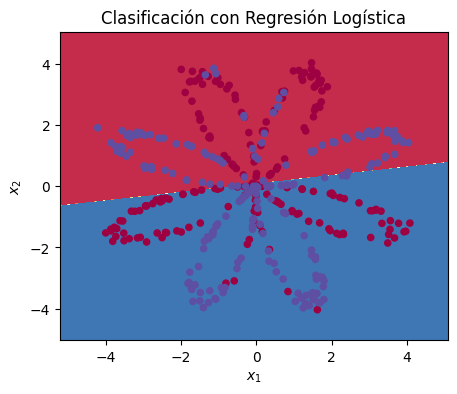

In [8]:
# Dibujamos las fronteras limites para la regresion logistica
plt.figure(figsize=(5, 4))
dibujar_fronteras_limite(lambda x: clasificador.predict(x), X, Y)
plt.title("Clasificación con Regresión Logística")

**Nota sobre el cálculo de la precisión (_accuraccy_)**:

$$\text{Precisión} = \frac{\text{Verdaderos Positivos} + \text{Verdaderos Negativos}}{\text{Total de Observaciones}} * 100 \tag{0}$$

En un problema de clasificación binaria hay varias formas de calcularlas. Dos formas que son del gusto del autor de este trabajo son:

Forma 1: 

$$\text{Precisión} = \frac{Y·Predicciones + (1 - Y)·(1 - Predicciones)}{\text{tamaño de Y}}$$

Forma 2: 

$$\text{Precisión} = 100 - \bar{T}$$ donde $\bar{T}$ es la media de $$T = |Predicciones - Y|$$

**IMPORTANTE**: Ojo con los tipos de datos de los arrays de NumPy a la hora de realizar operaciones. Las predicciones de sklearn devuelven un array de tipo **uint8**, que va de (0 a 255). El vector de etiquetas, _Y_, también es de tipo uint8, por lo que **su resta** puede dar como valor 255. Por ello hay que utilizar array.astype(int) o array.astype(float) para poder realizar correctamente los cálculos.

In [9]:
# Predicciones de la regresion logistica 
predicciones_RL = clasificador.predict(X.T) 

In [10]:
print(Y.dtype)
print(predicciones_RL.dtype)
print(predicciones_RL.astype(int).dtype)
print(predicciones_RL.astype(float).dtype)

uint8
uint8
int32
float64


In [11]:
print('Precisión de la regresión logística (Forma 1): %.2f ' % float((np.dot(Y, predicciones_RL) + 
        np.dot(1 - Y, 1 - predicciones_RL)) / float(Y.size) * 100) + "% (porcentaje de puntos correctamente clasificados).")
print(f'Precisión de la regresión logística (Forma 2): {100 - np.mean(np.abs(predicciones_RL.astype(float) - Y))*100} % (porcentaje de puntos correctamente clasificados).')

Precisión de la regresión logística (Forma 1): 47.00 % (porcentaje de puntos correctamente clasificados).
Precisión de la regresión logística (Forma 2): 47.0 % (porcentaje de puntos correctamente clasificados).


**Interpretación**: 

El conjunto de datos no es linealmente separable, por lo que la regresión logística no funciona bien. Veamos cómo una red neuronal clasifica muchísimo mejor los datos. 

Esto tiene todo el sentido del mundo en un problema de clasificación binaria como es este. _Y_ y _Predicciones_ son vectores, $" · "$ denota producto escalar, y como los valores de las etiquetas y predicciones solo pueden ser 0 y 1, las predicciones que coincidan se suman al total. En el caso de las coincidencias de etiquetas 0, para que sumen 1 es tan fácil como hacer (1 - 0).

<a name='4'></a>
## 4 - Modelo de red neuronal con dos capas (una capa oculta)

A continuación, crearemos el modelo de una red neuronal con una capa oculta y una capa de salida y compararemos resultados.

**Modelo**:
<img src="imagenes/red_neuronal_monocapa.png" style="width:649px;height:419px;">

<caption><center><b>Figura 1</b>: Estructura de red neuronal con una capa oculta.</center></caption>

**Fórmulas de la red neuronal**:

Para cada caso de entrenamiento $x^{(i)}$, se realizan los siguientes cálculos en cada capa:

$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{1}$$

$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$

$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{3}$$

$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$

$$y^{(i)}_{prediccion} = \begin{cases} 1 & \mbox{si } a^{[2](i)} > 0.5 \\ 0 & \mbox{de lo contrario } \end{cases}\tag{5}$$

El coste $J$ se calculará de la siguiente manera:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} L(a^{[2] (i)},  y^{(i)}) = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Metodología general para construir una red neuronal**:

1. Definir su estructura (número de unidades de entrada, número de unidades ocultas, número de capas, etc). 
2. Inicializar los parámetros del modelo.
3. Bucle de cálculo:
    - Implementar propagación hacia delante (_forward propagation_).
    - Calcular la pérdida.
    - Implementar la retropropagación (_backward propagation_) para calcular los gradientes.
    - Actualizar los parámetros (en caso de estar utilizando el algoritmo de descenso del gradiente).

Es habitual crear el código de los pasos por separado y luego integrar todos en una función que podemos llamar `rn_modelo()`. Una vez definida `rn_modelo()` y hallados los parámetros, se podrán realizar predicciones.

<a name='4-1'></a>
### 4.1 - Estructura de la red neuronal ####

Al ser una red neuronal de dos capas, hay tres variables que definen su estructura:

- **$n_x$**: tamaño de la capa de entrada. Equivale al número de diferentes características que componen cada ejemplo de entrenamiento. En nuestro caso, dos características.
- **$n_h$**: tamaño de la capa oculta, es decir, número de unidades ocultas ("neuronas") que componen la única capa oculta.
- **$n_y$**: tamaño de la capa de salida. Al ser un problema de clasificación binaria, su tamaño será uno.

<a name='4-2'></a>
### 4.2 - Inicialización de parámetros

A tener en cuenta:

- Asegurarse de que el tamaño de los parámetros es el correcto a la hora de inicializarlos. Para ello es importante crear el diagrama de la red neuronal, como se ve en la imagen del punto 4.
- Se pueden inicializar los parámetros de múltiples maneras. En este caso, se ha elegido la siguiente:
    - Inicializar las matrices de pesos con valores aleatorios.
    - Inicializar los vectores de sesgo como ceros.

In [12]:
def inicializar_parametros(n_x, n_h, n_y):
    """
    Argumentos:
    n_x -- tamaño de la capa de entrada
    n_h -- tamaño de la capa oculta
    n_y -- tamaño de la capa de salida
    
    Devuelve:
    parametros -- diccionario python que contiene los parámetros:
                    W1 -- matriz de pesos de la forma (n_h, n_x)
                    b1 -- vector de sesgos de la forma (n_h, 1)
                    W2 -- matriz de pesos de la forma (n_y, n_h)
                    b2 -- vector de sesgos de la forma (n_y, 1)                   
    """
    np.random.seed(2)
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape=(n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape=(n_y, 1))    

    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

<a name='4-3'></a>
### 4.3 - Propagación hacia delante (forward propagation)

Para ello se utilizarán las ecuaciones:

$$Z^{[1]} =  W^{[1]} X + b^{[1]}\tag{7}$$

$$A^{[1]} = \tanh(Z^{[1]})\tag{8}$$

$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}\tag{9}$$

$$\hat{Y} = A^{[2]} = \sigma(Z^{[2]})\tag{10}$$


**Consideraciones**:

- Para las funciones de activación, utilizaremos como se describe en la estructura las funciones sigmoide y tanh. La primera ya se ha utilizado previamente. La segunda es parte de la biblioteca NumPy, `np.tanh()`.
- La implementación consiste en los siguientes pasos:
    1. Obtenemos los parámetros iniciales del diccionario "parametros", que es la salida de `inicializar_parametros()`.
    2. La propagación hacia delante se halla calculando $Z^{[1]}, A^{[1]}, Z^{[2]}$ y $A^{[2]}$ (el vector de todas las predicciones sobre todos los datos de entrenamiento).
- Los valores necesarios en la retropropagación se almacenan en la "caché". La caché se dará como entrada a la función de retropropagación.

In [13]:
def sigmoide(z):
    """
    Calcula el sigmoide de z.
    
    Argumentos:
    z -- Un escalar o matriz numpy

    Devuelve:
    s -- sigmoide(z)
    """
    
    s = 1/(1 + np.exp(-z))
    
    return s

In [14]:
def forward_propagation(X, parametros):
    """
    Argumentos:
    X -- datos de entrada de tamaño (n_x, m)
    parametros -- diccionario python que contiene los parámetros iniciales (salida de la función de inicialización)
    
    Devuelve:
    A2 -- La salida sigmoidea de la segunda activación
    cache -- Diccionario que contiene "Z1", "A1", "Z2" y "A2"
    """

    W1 = parametros['W1']
    b1 = parametros['b1']
    W2 = parametros['W2']
    b2 = parametros['b2']    
    
    # Aplicar la propagación hacia delante para calcular A2 (probabilidades)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoide(Z2)    
    
    # Verificamos que las dimensiones son correctas; sino, detener la ejecucion
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

<a name='4-4'></a>
### 4.4 - Cálculo del coste global

Una vez calculada $A^{[2]}$ (almacenada en la llave `"A2"` y variable `A2`), la cual contiene $a^{[2](i)}$ para todos los ejemplos de entrenamiento, se puede calcular la función de coste de la siguiente manera, que es la pérdida de entropía cruzada:

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{11}$$

**Notas de implementación**: 

- Se utiliza `np.multiply()` y `np.sum()`, pero también podría utilizarse `np.dot()`.  
- Al utilizar `np.multiply` y `np.sum` el resultado es de tipo `float`, mientras que si se utiliza `np.dot`, el resultado es una matriz NumPy 2D.
- Si se utiliza `np.dot()`, para eliminar las dimensiones redundantes, se puede utilizar `np.squeeze()`. Y se puede castear/convertir al tipo deseado, por ejemplo, `float` utilizando `float()`.

In [15]:
def calcular_coste(A2, Y):
    """
    Calcula el coste de la entropía cruzada dado en la ecuación (11).
    
    Argumentos:
    A2 -- La salida sigmoidea de la segunda activación, de dimensiones (1, numero de casos de entrenamiento).
    Y -- Vector de etiquetas verdaderas de dimensiones (1, número de casos de entrenamiento).

    Devuelve
    coste -- coste de la entropía cruzada dada la ecuación (11).
    
    """
    
    # Numero de casos de entrenamiento
    m = Y.shape[1]

    # Calculo de la perdida de entropia cruzada
    perdida = np.multiply(np.log(A2), Y) + np.multiply((1 - Y), np.log(1 - A2))
    coste = - np.sum(perdida) / m    
    
    # En caso de utilizar np.dot()
    # coste = float(np.squeeze(coste))  # Convierte 2D array a float, por ejemplo, convierte [[17]] en 17 
    
    return coste

<a name='4-5'></a>
### 4.5 - Retropropagación (backward propagation)

Utilizando la caché calculada durante la propagación hacia delante, ahora se puede implementar la retropropagación.

**Consideraciones**:

La retropropagación suele ser la parte más difícil (la más matemática) del aprendizaje profundo. En la imagen a continuación se resumen las ecuaciones vistas en la teoría necesarias (izquierda sin vectorizar, derecha vectorizadas). Se utilizarán las seis ecuaciones de la derecha, ya que se está construyendo una **implementación vectorizada**.  

<img src="imagenes/retropropagacion.png" style="width:788px;height:421px;">
<caption><center><b>Figura 2</b>: Retropropagación en red neuronal con una capa oculta. Las ecuaciones de la izquierda son para cada ejemplo de entrenamiento. Las ecuaciones de la derecha son la versión vectorizada, aplicable a todo el conjunto de entrenamiento en una sola pasada.</center></caption>

- Recuérdese que $*$ significa multiplicación elemento a elemento.
- La notación reducida de las derivadas es equivalente a:
    $$dW^{[1]} = \frac{\partial \mathcal{J} }{ \partial W^{[1]} }$$
    $$db^{[1]} = \frac{\partial \mathcal{J} }{ \partial b^{[1]} }$$
    $$dW^{[2]} = \frac{\partial \mathcal{J} }{ \partial W^{[2]} }$$
    $$db^{[2]} = \frac{\partial \mathcal{J} }{ \partial b^{[2]} }$$
- Sobre el cálculo de $g^{[1]'}(Z^{[1]})$:
    - Para calcular $dZ_1$ es necesario hallar $g^{[1]'}(Z^{[1]})$. Dado que $g^{[1]}(...)$ es equivalente a la función de activación $tanh$, la derivada de la ecuación (2) es $A^{[1]´} = g^{[1]'}(Z^{[1]}) = 1-(A^{[1)})^2$.

In [16]:
def backward_propagation(parametros, cache, X, Y):
    """
    Implementa la retropropagacion siguiendo las instrucciones anteriores.
    
    Argumentos:
    parametros -- diccionario python que contiene los parámetros del modelo.
    cache -- diccionario que contiene "Z1", "A1", "Z2" y "A2".
    X -- datos de entrada de dimensiones (2, numero de casos de entrenamiento)
    Y -- vector de etiquetas verdaderas de dimensiones (1, numero de casos de entrenamiento)
    
    Devuelve
    gradientes -- diccionario python que contiene los gradientes con respecto a los parámetros.
    """
    # Numero de ejemplos de entrenamiento
    m = X.shape[1]
    
    # Recuperamos W1 y W2 del diccionario "parametros".
    W1 = parametros['W1']
    W2 = parametros['W2']    
        
    # Recuperamos A1 y A2 del diccionario "cache".
    A1 = cache['A1']
    A2 = cache['A2']    

    # Retropropagacion: calcular dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = (1 / m) * np.dot(dZ2, A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.multiply(np.dot(W2.T, dZ2), 1 - np.power(A1, 2))
    dW1 = (1 / m) * np.dot(dZ1, X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)    

    gradientes = {"dW1": dW1,
                  "db1": db1,
                  "dW2": dW2,
                  "db2": db2}
    
    return gradientes

<a name='4-6'></a>
### 4.6 - Actualización de los parámetros

Aplicar la regla de actualización del descenso del gradiente.

**Regla general del descenso del gradiente**: $\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ donde $\alpha$ es la tasa de aprendizaje y $\theta$ representa cada parámetro actualizable.

In [17]:
def actualizar_parametros(parametros, gradientes, tasa_aprendizaje = 1.1):
    """
    Actualiza los parametros utilizando la regla de actualización por descenso de gradiente.
    
    Argumentos:
    parametros -- diccionario python que contiene los parametros 
    gradientes -- diccionario python que contiene los gradientes
    tasa_aprendizaje -- hiperparametro que representa la tasa de aprendizaje utilizada en la regla de actualizacion
    
    Devuelve:
    parametros -- diccionario python que contiene los parametros actualizados 
    """
    # Recupera una copia de cada parámetro del diccionario "parametros".
    W1 = parametros['W1']
    b1 = parametros['b1']
    W2 = parametros['W2']
    b2 = parametros['b2']    
    
    # Recuperar cada gradiente del diccionario "gradientes".
    dW1 = gradientes['dW1']
    db1 = gradientes['db1']
    dW2 = gradientes['dW2']
    db2 = gradientes['db2']    
    
    # Aplicar regla de actualizacion a cada parametro
    W1 = W1 - tasa_aprendizaje * dW1
    b1 = b1 - tasa_aprendizaje * db1
    W2 = W2 - tasa_aprendizaje * dW2
    b2 = b2 - tasa_aprendizaje * db2    

    parametros = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parametros

<a name='4-7'></a>
### 4.7 - Integración del modelo

A continuación, juntamos todas las funciones para construir el modelo de red neuronal de dos capas en la función `rn_model()`.

**Importante**: Las funciones tienen que ir en el orden adecuado para funcionar correctamente.

In [18]:
def rn_modelo(X, Y, n_h, num_iteraciones = 11000, dibujar_coste=False):
    """
    Argumentos:
    X -- conjunto de datos de la forma (2, numero de ejemplos)
    Y -- vector de etiquetas verdaderas de dimensiones (1, numero de ejemplos)
    n_h -- tamaño de la capa oculta
    num_iteraciones -- hiperparámetro que representa el número de iteraciones para optimizar los parámetros
    dibujar_coste -- si es True, imprime el coste cada 1000 iteraciones
    
    Devuelve:
    parametros -- parametros hallados por el modelo; pueden utilizarse para hacer predicciones.
    """
    
    np.random.seed(3)
    # n_x -- tamaño de la capa de entrada
    n_x = X.shape[0]
    # n_y -- tamaño de la capa de salida
    n_y = Y.shape[0]
    
    # Inicializamos los parametros
    parametros = inicializar_parametros(n_x, n_h, n_y)
    
    # Bucle que aplica el descenso del gradiente
    for i in range(0, num_iteraciones):
        # Forward propagation
        A2, cache = forward_propagation(X, parametros)
        
        # Funcion de coste
        coste = calcular_coste(A2, Y)
        
        # Backpropagation
        gradientes = backward_propagation(parametros, cache, X, Y)
        
        # Regla de actualizacion de parametros
        parametros = actualizar_parametros(parametros, gradientes)
        
        # Mostrar el coste cada 1000 iteraciones
        if dibujar_coste and i % 1000 == 0:
            print("Coste tras cada iteración %i: %f" % (i, coste))
            
    return parametros

<a name='5'></a>
## 5 - Evaluación del modelo

<a name='5-1'></a>
### 5.1 - Predicción

La función anterior mostrará los valores aprendidos de $W^{[l]}$ y $b^{[l]}$. Podemos utilizarlos para predecir las etiquetas de un conjunto de datos X. Hay dos pasos para calcular las predicciones:

1. Calculamos $\hat{Y} = A^{[2]}$ con los valores de $W^{[l]}$ y $b^{[l]}$ hallados usando la propagación hacia delante.

2. Convertirmos cada uno de los valores de $A^{[2]}$ en 0 (si el valor de activación es <= 0.5) o 1 (si la activación es > 0.5) y lo almacenamos en un vector `predicciones`.

**Recordatorio**: Para cada predicción se aplica la ecuación (5). Hay varias maneras de implementarlo, de las cuales se muestran dos:
1. `prediccion = (prediccion > umbral)`, siendo umbral = 0.5.
2. `np.round(prediccion)`, como dice la documentación: "Para valores exactamente a medio camino entre valores decimales redondeados, NumPy redondea al valor par más cercano. Así, 1.5 y 2.5 redondean a 2.0; -0.5 y 0.5 redondean a 0.0, etc.".

In [19]:
np.round(0.5)

0.0

In [20]:
def predecir(parametros, X):
    """
    Utilizando los parámetros aprendidos, predice una clase para cada ejemplo en X.
    
    Argumentos:
    parametros -- diccionario python que contiene sus parámetros.
    X -- datos de entrada de tamaño (n_x, m).
    
    Devuelve:
    predicciones -- vector de predicciones de nuestro modelo (rojo: 0 / azul: 1).
    """
    
    # Calcula las probabilidades utilizando la propagación hacia delante, y clasifica a 0/1 utilizando 0,5 como umbral.
    A2, cache = forward_propagation(X, parametros)
    predicciones = np.round(A2)
    
    return predicciones

<a name='5-2'></a>
### 5.2 - Evaluación sobre el conjunto de datos

Ejecutemos el modelo y veamos su rendimiento. Se utilizará en un primer momento en la capa oculta $n_h = 4$ unidades ocultas.

Coste tras cada iteración 0: 0.693048
Coste tras cada iteración 1000: 0.290090
Coste tras cada iteración 2000: 0.272942
Coste tras cada iteración 3000: 0.236822
Coste tras cada iteración 4000: 0.228702
Coste tras cada iteración 5000: 0.224190
Coste tras cada iteración 6000: 0.221093
Coste tras cada iteración 7000: 0.218748
Coste tras cada iteración 8000: 0.216879
Coste tras cada iteración 9000: 0.215355
Coste tras cada iteración 10000: 0.214094


Text(0.5, 1.0, 'Fronteras con red neuronal con 4 unidades ocultas')

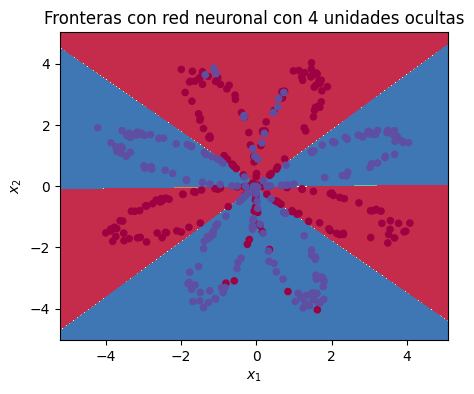

In [21]:
# Construccion del modelo de red neuronal de una capa oculta n_h-dimensional
parametros = rn_modelo(X, Y, n_h = 4, num_iteraciones = 11000, dibujar_coste=True)

# # Dibujamos las fronteras limites para la red neuronal
plt.figure(figsize=(5, 4))
dibujar_fronteras_limite(lambda x: predecir(parametros, x.T), X, Y)
plt.title("Fronteras con red neuronal con " + str(4) + " unidades ocultas")

La precisión se calcula con la ecuación (0). Al restar uint8 y float64, prevalece la conversión a float64 y por ello no hay que utilizar `.astype(float)`.

In [22]:
predicciones = predecir(parametros, X)

In [23]:
print(Y.dtype)
print(predicciones.dtype)

uint8
float64


In [24]:
print('Precision (Forma 1): %.2f' % float((np.dot(Y, predicciones.T) + np.dot(1 - Y, 1 - predicciones.T)) / float(Y.size) * 100) + ' %')
print(f'Precisión (Forma 2): {100 - np.mean(np.abs(predicciones.astype(float) - Y))*100} %')

Precision (Forma 1): 90.75 %
Precisión (Forma 2): 90.75 %


La mejor opción para visualizar la precisión conseguida es la matriz de confusión, para lo cual nos valdremos de la biblioteca sklearn. Hay que convertir los datos en un array unidemensional para que funcione la función:

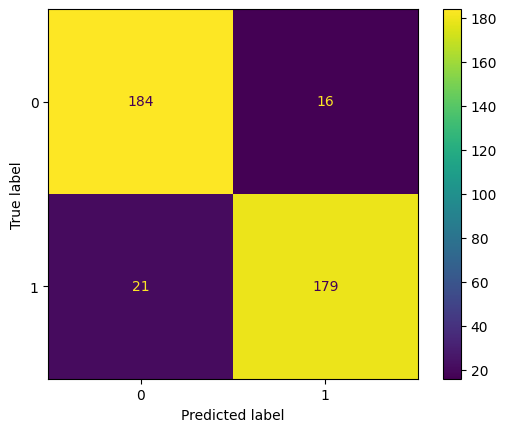

In [25]:
cm = confusion_matrix(np.squeeze(Y.reshape(-1,1)), np.squeeze(predicciones.reshape(-1,1)))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)

cm_display.plot()
plt.show()

**Interpretación**:

La precisión es realmente alta en comparación con la regresión logística. A diferencia de la regresión logística, las redes neuronales son capaces de aprender fronteras de decisión no lineales. 

<a name='6'></a>
## 6 - Ajuste del tamaño de la capa oculta (_fine tuning_)

Veamos el comportamiento del modelo para diversos tamaños de la capa oculta, $n_h$ diferentes al utilizado.

Precisión para 1 unidades ocultas: 67.25 %
Precisión para 2 unidades ocultas: 67.0 %
Precisión para 3 unidades ocultas: 90.5 %
Precisión para 5 unidades ocultas: 91.0 %
Precisión para 15 unidades ocultas: 90.5 %
Precisión para 40 unidades ocultas: 90.25 %
Precisión para 70 unidades ocultas: 90.5 %


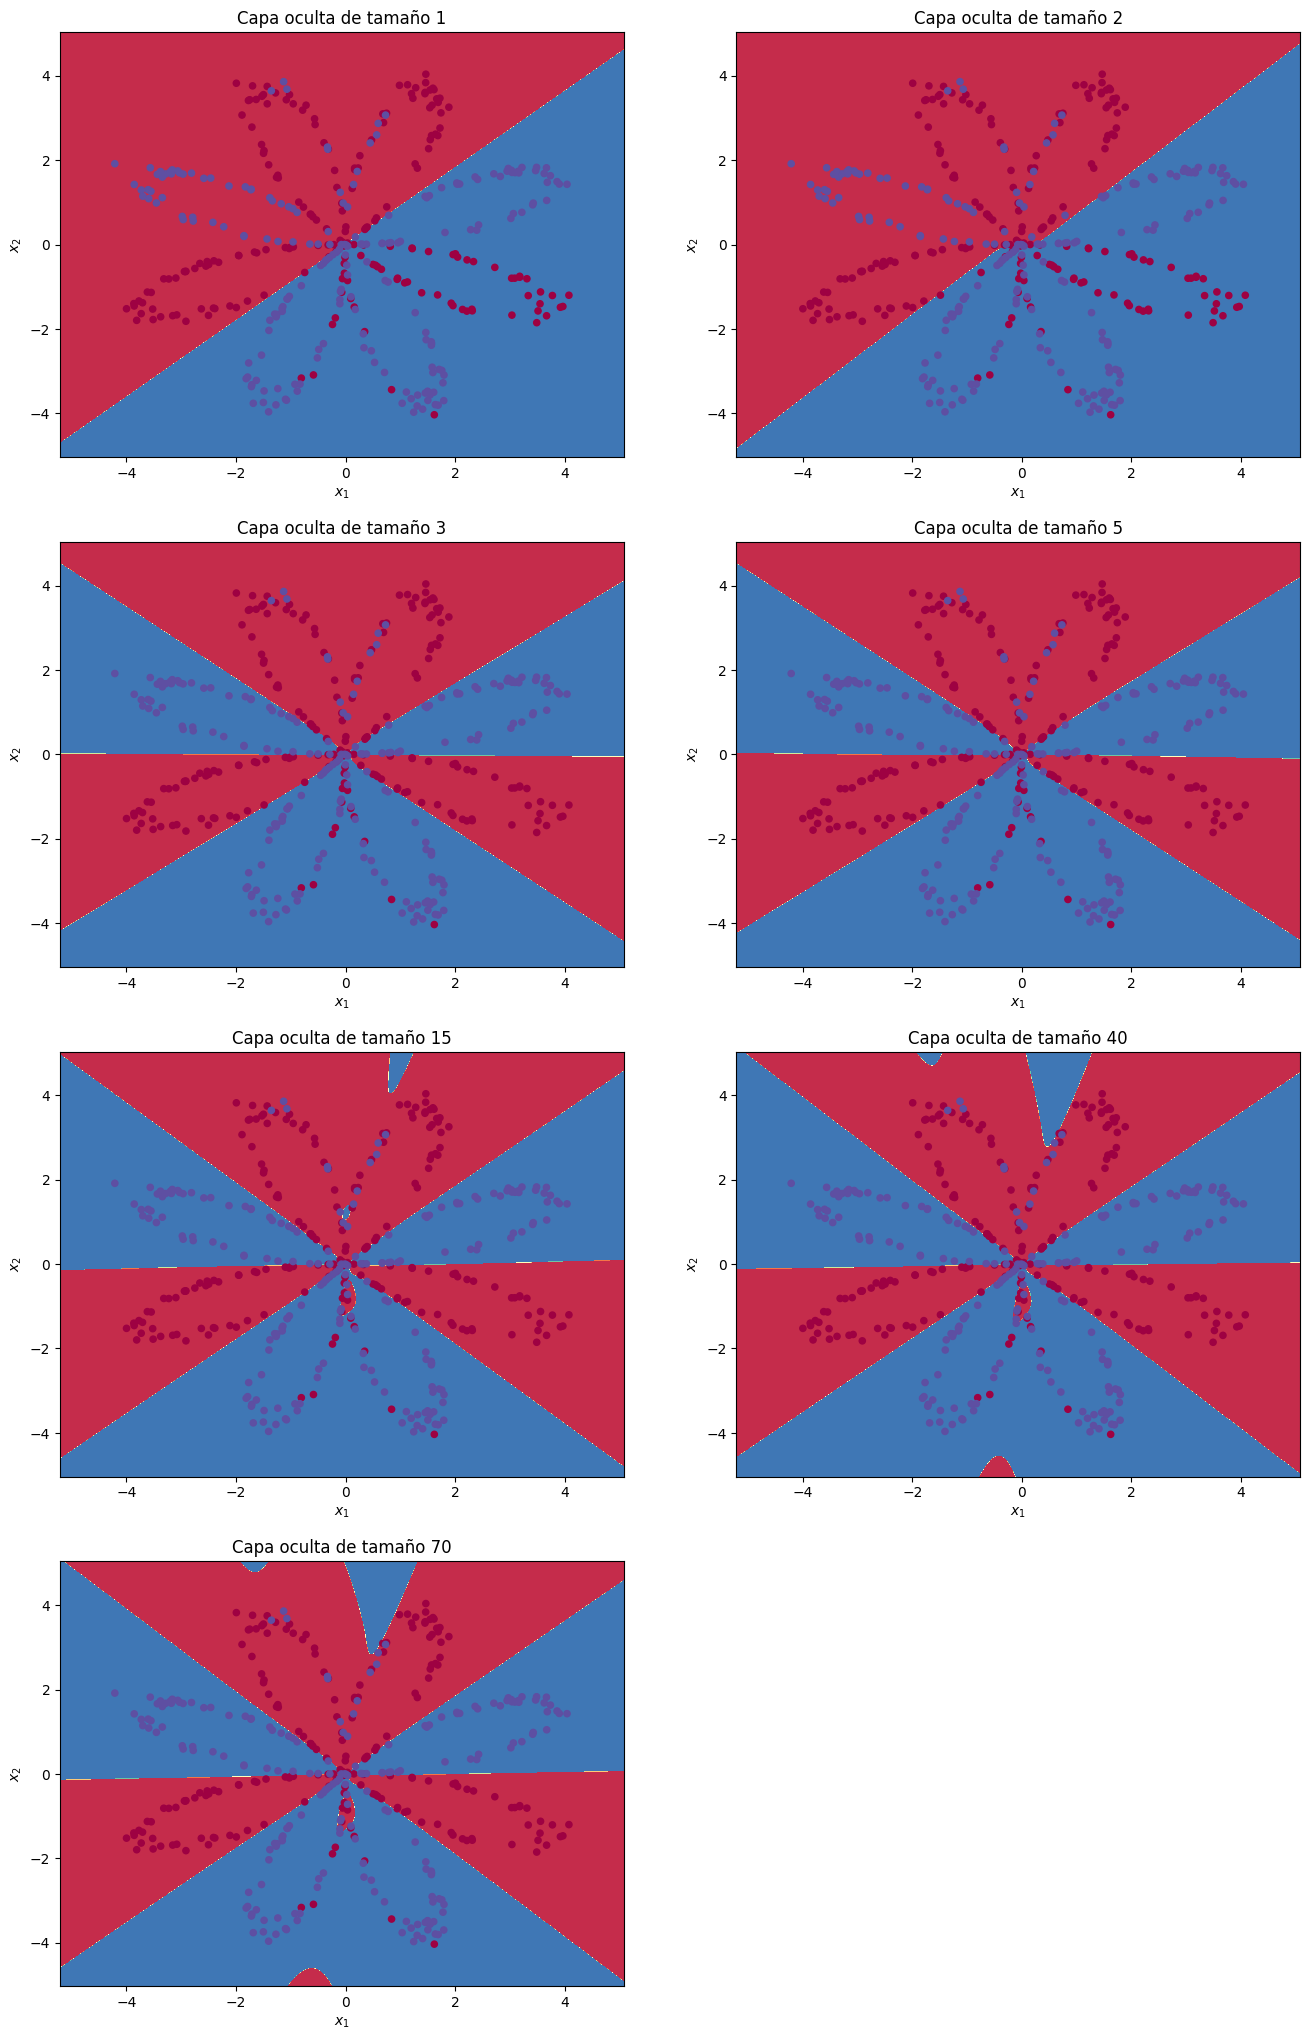

In [26]:
plt.figure(figsize=(16, 32))
numero_n_h = [1, 2, 3, 5, 15, 40, 70]
for i, n_h in enumerate(numero_n_h):
    plt.subplot(5, 2, i + 1)
    plt.title('Capa oculta de tamaño %d' % n_h)
    parametros = rn_modelo(X, Y, n_h, num_iteraciones=4000)
    dibujar_fronteras_limite(lambda x: predecir(parametros, x.T), X, Y)
    predicciones = predecir(parametros, X)
    precision = float((np.dot(Y,predicciones.T) + np.dot(1 - Y, 1 - predicciones.T)) / float(Y.size)*100)
    print("Precisión para {} unidades ocultas: {} %".format(n_h, precision))

**Interpretación de resultados:**:

- Los modelos grandes (con más unidades ocultas) son capaces de ajustarse mejor al conjunto de entrenamiento, hasta que finalmente los modelos más grandes sobreajustan (_overfitting_) los datos. 
- El mejor tamaño de capa oculta parece estar en torno a $n_h = 5$. De hecho, un valor cercano a este parece ajustarse bien a los datos sin incurrir en un sobreajuste notable.
- Para poder utilizar modelos muy grandes (con, por ejemplo, $n_h = 70$) sin demasiado sobreajuste, habría que utilizar técnicas como la regularización.

**Cambios sencillos en el modelo para intentar mejorar la precisión**:

- Cambiar la función de activación de la capa oculta por otra función no lineal, por ejemplo, ReLU.
- Variar el valor de la tasa de aprendizaje.

Otras fuentes consultadas:
    
Stanford University CS231n: Deep Learning for Computer Vision    
- http://cs231n.github.io/neural-networks-case-study/